## Goal is to look at given set of chest X-Ray images and create a model to classify whether a patient have Lung Opacity or not. If there is a lung opacity, provide marking. There is a third class "No lung opacity/Not normal" which is nothing but there is no peunomonia but the lung doesnot look normal too. We can optionally have marking for the third class.


## 1. Load image files and look at few images

In [15]:
%matplotlib inline

import math as math
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [2]:
zip_directory='/tmp'

In [3]:
#from google.colab import drive
#drive.mount('/content/drive/')
#mainZipFile = ZipFile("drive/My Drive/Colab Notebooks/CV capstone-20230330T235201Z-002.zip", 'r')
#mainZipFile.extractall(zip_directory)
#mainZipFile.close()

In [4]:
mainZipFile = ZipFile("CV capstone-20230330T235201Z-002.zip")
mainZipFile.extractall(zip_directory)

## 2. List all files inside zip

In [5]:
mainZipFile.filelist

[<ZipInfo filename='CV capstone/stage_2_sample_submission.csv' compress_type=deflate file_size=159027 compress_size=65360>,
 <ZipInfo filename='CV capstone/stage_2_detailed_class_info.csv' compress_type=deflate file_size=1647396 compress_size=597052>,
 <ZipInfo filename='CV capstone/stage_2_train_labels.csv' compress_type=deflate file_size=1490034 compress_size=676860>,
 <ZipInfo filename='CV capstone/GCP Credits Request Link - RSNA.txt' compress_type=deflate file_size=55 compress_size=57>,
 <ZipInfo filename='CV capstone/stage_2_test_images.zip' compress_type=deflate file_size=397164167 compress_size=397224772>]

###### We have three csv and zip file
###### We have another Link file which we can ignore as it is having only credit information


## Read all csv files and check content

In [6]:
train_label_df = pd.read_csv("CV capstone/stage_2_train_labels.csv")
sample_submission_df = pd.read_csv("CV capstone/stage_2_sample_submission.csv")
class_info_df = pd.read_csv("CV capstone/stage_2_detailed_class_info.csv")

In [7]:
class_info_df

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


In [8]:
sample_submission_df

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100
...,...,...
2995,c1e88810-9e4e-4f39-9306-8d314bfc1ff1,0.5 0 0 100 100
2996,c1ec035b-377b-416c-a281-f868b7c9b6c3,0.5 0 0 100 100
2997,c1ef5b66-0fd7-49d1-ae6b-5af84929414b,0.5 0 0 100 100
2998,c1ef6724-f95f-40f1-b25b-de806d9bc39d,0.5 0 0 100 100


###### The submission CSV file will be useful to verify the result of model and come up with accuracy measurement.

In [9]:
train_label_df

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


###### The lable file has patientid and coordinates and what is target?

<AxesSubplot:xlabel='Target', ylabel='count'>

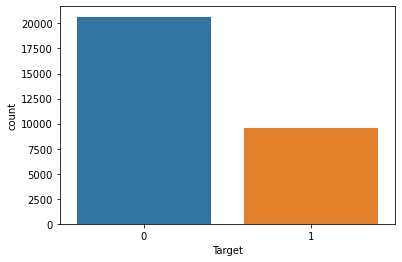

In [10]:
sns.countplot(x=train_label_df['Target'])

<AxesSubplot:xlabel='class', ylabel='count'>

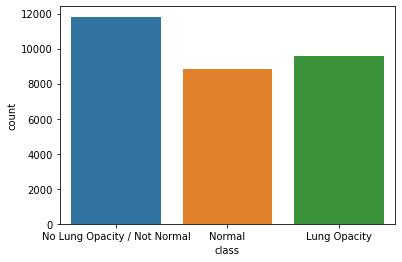

In [11]:
sns.countplot(x=class_info_df['class'])

#### We have training images in another zip file.

In [12]:
training_image_zip_file="CV capstone/stage_2_train_images-001.zip"
trainImgZipFile = ZipFile(training_image_zip_file, 'r')
trainImgZipFile.extractall(zip_directory + "/train_images")
trainImgZipFile.close()
trainImgZipFile.filelist

[<ZipInfo filename='stage_2_train_images/' filemode='drwxr-xr-x'>,
 <ZipInfo filename='__MACOSX/._stage_2_train_images' compress_type=deflate filemode='-rwxr-xr-x' file_size=212 compress_size=135>,
 <ZipInfo filename='stage_2_train_images/7be6b4de-afe9-43c0-a581-0f49608c8976.dcm' compress_type=deflate filemode='-rw-rw-r--' file_size=149466 compress_size=147827>,
 <ZipInfo filename='__MACOSX/stage_2_train_images/._7be6b4de-afe9-43c0-a581-0f49608c8976.dcm' compress_type=deflate filemode='-rw-rw-r--' file_size=212 compress_size=135>,
 <ZipInfo filename='stage_2_train_images/2dcdd159-2889-48d3-a0ce-5c7b1086c49d.dcm' compress_type=deflate filemode='-rw-rw-r--' file_size=163514 compress_size=162647>,
 <ZipInfo filename='__MACOSX/stage_2_train_images/._2dcdd159-2889-48d3-a0ce-5c7b1086c49d.dcm' compress_type=deflate filemode='-rw-rw-r--' file_size=212 compress_size=135>,
 <ZipInfo filename='stage_2_train_images/d8e66874-305e-4c80-9b75-5e764eb718ff.dcm' compress_type=deflate filemode='-rw-rw-r-

## Let us look at few images

In [13]:
!pip install pydicom

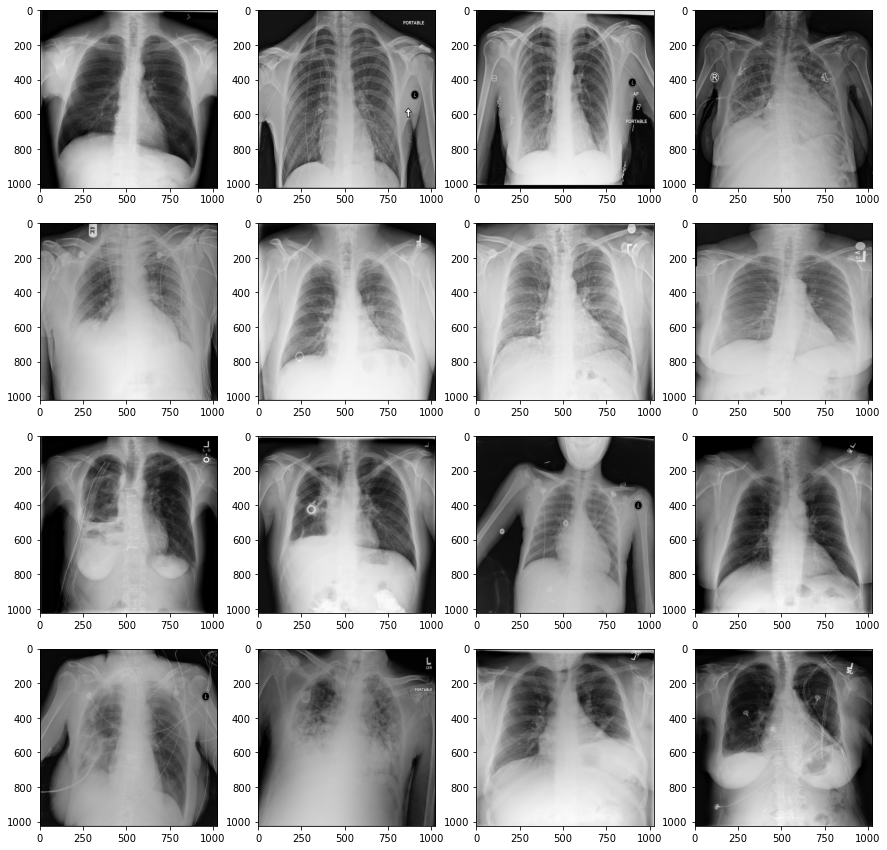

In [16]:
# Print few images with its class 
import random
import pydicom as dicom

fig = plt.figure(figsize=(15, 15))
N=16
for i in range(1, N+1):
    #loc = random.randint(1, total_number_of_files)
    random_file=random.choice(os.listdir(zip_directory + "/train_images/stage_2_train_images"))
    #print(random_file)
    fig.add_subplot(4, 4, i)
    dicom_image = dicom.dcmread(zip_directory + "/train_images/stage_2_train_images/" + random_file)
    plt.imshow(dicom_image.pixel_array, cmap=plt.cm.gray)
   # plt.title(data.loc[loc, 'class'])
   # plt.axis('off')
plt.show()

## Iterate over image directory, resize images to 32  * 32 and normalize the image array. Also store the original image size


In [98]:
!pip install tensorflow_io

  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.29.0
    Uninstalling tensorflow-io-gcs-filesystem-0.29.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.29.0


In [115]:
import os
import pydicom as dicom
import skimage.transform as st
import tensorflow as tf
import tensorflow_io as tfio

image_directory = zip_directory + "/train_images/stage_2_train_images"
total_number_of_files = 0
image_df = pd.DataFrame(columns=['image_file_name', 'path', 'actual_image', 'height', 'width'])

# Iterate directory
i = 0
for file in os.listdir(image_directory):
    # check if current path is a file
    if os.path.isfile(os.path.join(image_directory, file)):
        total_number_of_files += 1
        dicom_image = dicom.dcmread(os.path.join(image_directory, file))
        image_df.loc[i, 'path'] = os.path.join(image_directory, file)
        image_df.loc[i, 'image_file_name'] = file
        #image_df.loc[i, 'patientId'] = data.loc[loc, 'patientId']
        #image_df.loc[i, 'actual_image'] = dicom_image.pixel_array 
        image_df.loc[i, 'actual_image'] = np.array((st.resize(dicom_image.pixel_array, (32, 32), anti_aliasing=True))/255)
                
        image_df.loc[i, 'height'] = dicom_image.Columns
        image_df.loc[i, 'width'] = dicom_image.Rows
        i+=1
        #if (i == 100):
        #    break
print(f"We have {total_number_of_files} total number of image files");


We have 26684 total number of image files


In [116]:
image_df

,image_file_name,path,actual_image,height,width
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,/tmp/train_images/stage_2_train_images\0004cfa...,"[[8.286463581287197e-05, 4.041750331910769e-05...",1024,1024
1,000924cf-0f8d-42bd-9158-1af53881a557.dcm,/tmp/train_images/stage_2_train_images\000924c...,"[[7.194814904496719e-05, 0.0002037581145740258...",1024,1024
2,000db696-cf54-4385-b10b-6b16fbb3f985.dcm,/tmp/train_images/stage_2_train_images\000db69...,"[[4.487527018563684e-05, 4.5375053597157953e-0...",1024,1024
3,000fe35a-2649-43d4-b027-e67796d412e0.dcm,/tmp/train_images/stage_2_train_images\000fe35...,"[[0.0002417167778605627, 0.0002527935192363741...",1024,1024
4,001031d9-f904-4a23-b3e5-2c088acd19c6.dcm,/tmp/train_images/stage_2_train_images\001031d...,"[[6.772987099858779e-05, 0.0003000979514369435...",1024,1024
...,...,...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3.dcm,/tmp/train_images/stage_2_train_images\fffb239...,"[[7.163705612606939e-05, 6.700455796513645e-05...",1024,1024
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27.dcm,/tmp/train_images/stage_2_train_images\fffba05...,"[[4.6134528863375316e-05, 4.610083468755934e-0...",1024,1024
26681,fffc95b5-605b-4226-80ab-62caec682b22.dcm,/tmp/train_images/stage_2_train_images\fffc95b...,"[[0.0003491565798057978, 0.000770259978522427,...",1024,1024
26682,fffcff11-d018-4414-971a-a7cefa327795.dcm,/tmp/train_images/stage_2_train_images\fffcff1...,"[[1.344063738425597e-05, 4.654971683902636e-07...",1024,1024


## The image_file_name has both extension and patienid. Split and store it.

In [117]:
image_df[['patientId', 'extension']] = image_df['image_file_name'].str.split('.', 1, expand=True)

In [120]:
image_df.shape

(26684, 7)

In [121]:
image_df[image_df.duplicated('patientId') == True]

,image_file_name,path,actual_image,height,width,patientId,extension


In [123]:
train_label_df.shape

(26684, 6)

## Train label CSV sounds like having some duplicate - remove it.

In [124]:
train_label_df = train_label_df[train_label_df.duplicated('patientId') == False]

In [125]:
train_label_df.shape

(26684, 6)

In [126]:
data = image_df.merge(train_label_df, on="patientId")

In [127]:
data.shape

(26684, 12)

In [128]:
class_info_df = class_info_df[class_info_df.duplicated('patientId') == False]

In [129]:
data = data.merge(class_info_df, on="patientId")

In [130]:
first_column = data.pop('patientId')
data.insert(0, 'patientId', first_column)

In [131]:
data.shape

(26684, 13)

## Print random images from data from array 

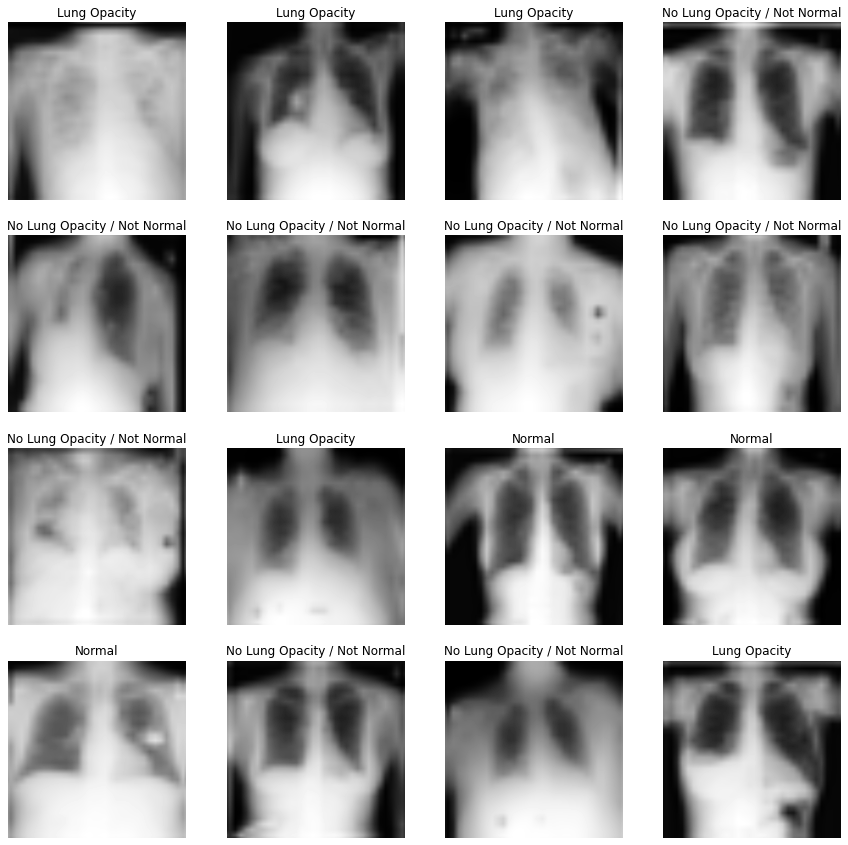

In [132]:
# Print few images with its class 
import random
import pydicom as dicom

fig = plt.figure(figsize=(15, 15))
N=16
for i in range(1, N+1):
    loc = random.randint(1, total_number_of_files)
    #random_file=random.choice(os.listdir(zip_directory + "/train_images/stage_2_train_images"))
    #print(random_file)
    fig.add_subplot(4, 4, i)
    #dicom_image = dicom.dcmread(data.loc[loc, 'actual_image'])    
    plt.imshow(st.resize(data.loc[loc, 'actual_image'],  (1024, 1024)),  cmap=plt.cm.gray)
    plt.title(data.loc[loc, 'class'])
    plt.axis('off')
plt.show()

##### We have lost the image quality after we have created dataframe with image array after resizing.

## Check the "Class" balance

<AxesSubplot:xlabel='class', ylabel='count'>

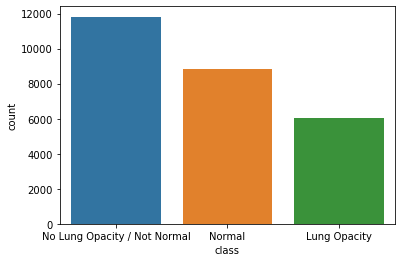

In [133]:
sns.countplot(x=data["class"])

######  Class is not balanced 

## Let us encode class variable

In [134]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'class'.
data['class_no']= label_encoder.fit_transform(data['class'])
df = data.drop(labels='class', axis=1)
df

,patientId,image_file_name,path,actual_image,height_x,width_x,extension,x,y,width_y,height_y,Target,class_no
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,/tmp/train_images/stage_2_train_images\0004cfa...,"[[8.286463581287197e-05, 4.041750331910769e-05...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,1
1,000924cf-0f8d-42bd-9158-1af53881a557,000924cf-0f8d-42bd-9158-1af53881a557.dcm,/tmp/train_images/stage_2_train_images\000924c...,"[[7.194814904496719e-05, 0.0002037581145740258...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,2
2,000db696-cf54-4385-b10b-6b16fbb3f985,000db696-cf54-4385-b10b-6b16fbb3f985.dcm,/tmp/train_images/stage_2_train_images\000db69...,"[[4.487527018563684e-05, 4.5375053597157953e-0...",1024,1024,dcm,316.0,318.0,170.0,478.0,1,0
3,000fe35a-2649-43d4-b027-e67796d412e0,000fe35a-2649-43d4-b027-e67796d412e0.dcm,/tmp/train_images/stage_2_train_images\000fe35...,"[[0.0002417167778605627, 0.0002527935192363741...",1024,1024,dcm,570.0,282.0,269.0,409.0,1,0
4,001031d9-f904-4a23-b3e5-2c088acd19c6,001031d9-f904-4a23-b3e5-2c088acd19c6.dcm,/tmp/train_images/stage_2_train_images\001031d...,"[[6.772987099858779e-05, 0.0003000979514369435...",1024,1024,dcm,66.0,160.0,373.0,608.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,fffb2395-8edd-4954-8a89-ffe2fd329be3.dcm,/tmp/train_images/stage_2_train_images\fffb239...,"[[7.163705612606939e-05, 6.700455796513645e-05...",1024,1024,dcm,177.0,285.0,225.0,529.0,1,0
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,fffba05a-1635-4545-9bbd-57ad4cfe8d27.dcm,/tmp/train_images/stage_2_train_images\fffba05...,"[[4.6134528863375316e-05, 4.610083468755934e-0...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,2
26681,fffc95b5-605b-4226-80ab-62caec682b22,fffc95b5-605b-4226-80ab-62caec682b22.dcm,/tmp/train_images/stage_2_train_images\fffc95b...,"[[0.0003491565798057978, 0.000770259978522427,...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,1
26682,fffcff11-d018-4414-971a-a7cefa327795,fffcff11-d018-4414-971a-a7cefa327795.dcm,/tmp/train_images/stage_2_train_images\fffcff1...,"[[1.344063738425597e-05, 4.654971683902636e-07...",1024,1024,dcm,NaN,NaN,NaN,NaN,0,1


In [135]:
df[df.duplicated('patientId') == True]

,patientId,image_file_name,path,actual_image,height_x,width_x,extension,x,y,width_y,height_y,Target,class_no


## EDA and Plots

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26684 entries, 0 to 26683
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patientId        26684 non-null  object 
 1   image_file_name  26684 non-null  object 
 2   path             26684 non-null  object 
 3   actual_image     26684 non-null  object 
 4   height_x         26684 non-null  object 
 5   width_x          26684 non-null  object 
 6   extension        26684 non-null  object 
 7   x                6012 non-null   float64
 8   y                6012 non-null   float64
 9   width_y          6012 non-null   float64
 10  height_y         6012 non-null   float64
 11  Target           26684 non-null  int64  
 12  class_no         26684 non-null  int32  
dtypes: float64(4), int32(1), int64(1), object(7)
memory usage: 3.8+ MB


In [137]:
df.isna().sum()

patientId              0
image_file_name        0
path                   0
actual_image           0
height_x               0
width_x                0
extension              0
x                  20672
y                  20672
width_y            20672
height_y           20672
Target                 0
class_no               0
dtype: int64

In [138]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x,6012.0,385.402861,204.434449,6.0,203.0,305.0,592.0,816.0
y,6012.0,376.535429,149.040913,2.0,258.0,379.0,488.0,881.0
width_y,6012.0,216.059880,59.472632,40.0,174.0,214.0,257.0,528.0
height_y,6012.0,314.020126,154.697456,45.0,192.0,282.0,415.0,867.0
Target,26684.0,0.225304,0.417790,0.0,0.0,0.0,0.0,1.0
class_no,26684.0,1.106393,0.738716,0.0,1.0,1.0,2.0,2.0


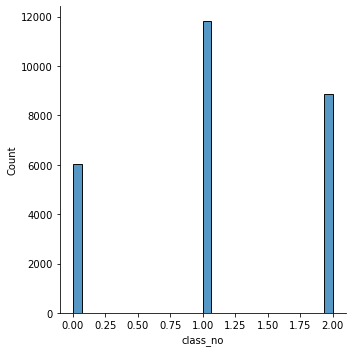

In [139]:
sns.displot(df, x='class_no', discrete=False)

<AxesSubplot:>

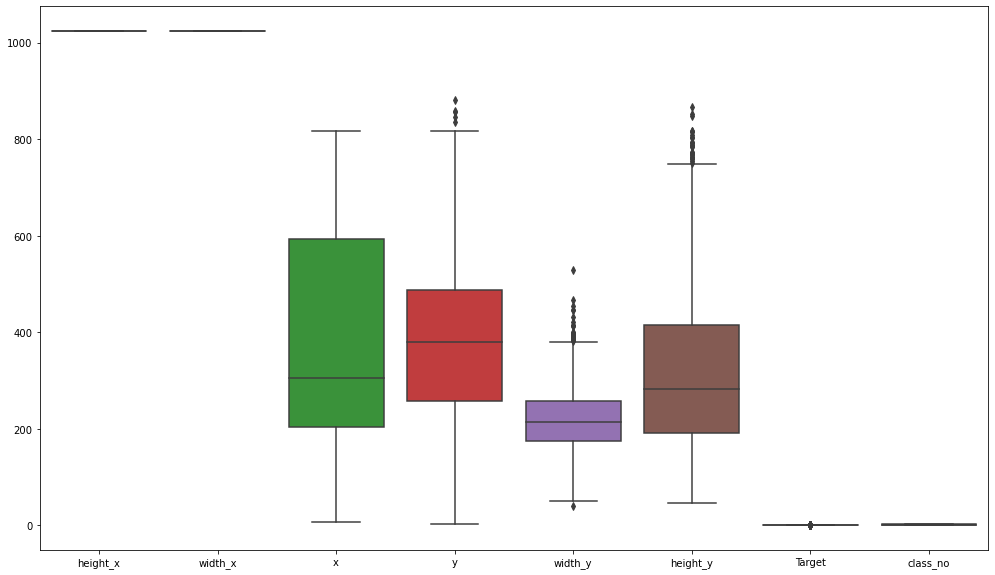

In [140]:
plt.figure(figsize=(17,10))
sns.boxplot(data=df)

##### All images are 1024 * 1024
##### The image marker X are between 300 to 600 and 75% of the X are between 300 to 600.
##### The Image marker Y are between 250 to 500 and 75% of Y are between 250 to 400. We have few Y value beyond 900
##### The length of the marker is between 180 to 220. We have few goes upto 400
##### The highet of the marker is between 200 to 400. We have some bigger Y which is beyond 700.
##### Overall we have average bounding box with some large boxes as well.

## Display random images with bounding box

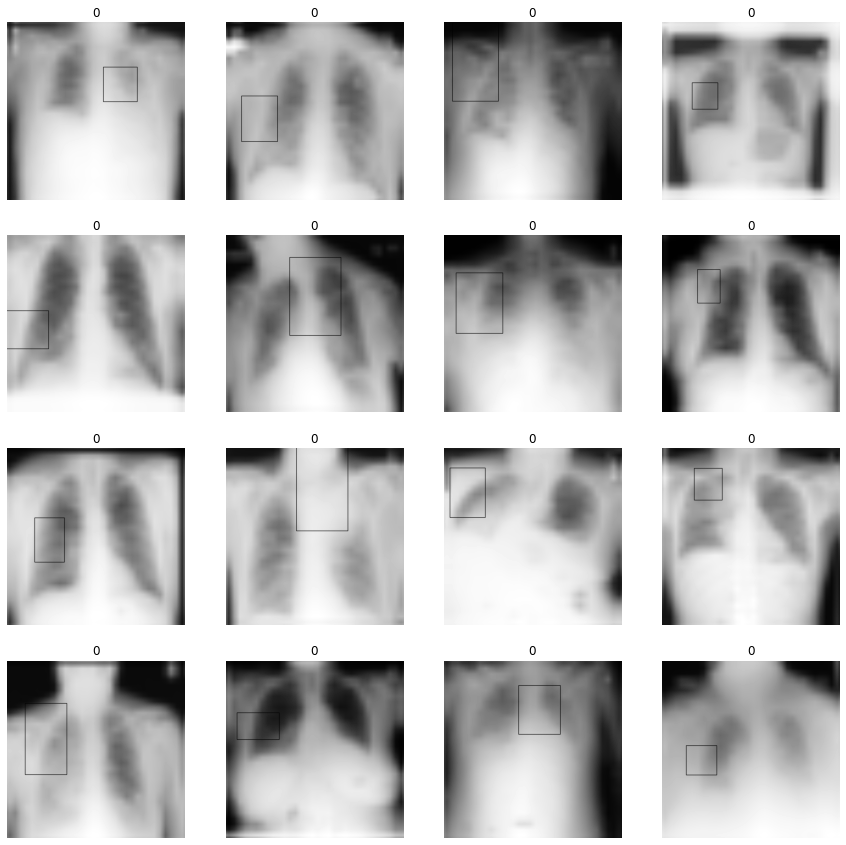

In [147]:
import cv2
import random

fig = plt.figure(figsize=(15, 15))
N=16
i = 0
#temp_df = df.query("x != nan").sample(n=200)
temp_df = df.loc[df['x'].notnull()]
temp_df = temp_df.sample(100, ignore_index=True)
#print(temp_df)
for i in range(1, N+1):
    loc = random.randint(1, len(temp_df))
    fig.add_subplot(4, 4, i)

    x0 = temp_df.loc[loc, 'x'] - temp_df.loc[loc, 'width_y'] / 2
    x1 = temp_df.loc[loc, 'x'] + temp_df.loc[loc, 'width_y'] / 2
    y0 = temp_df.loc[loc, 'y'] - temp_df.loc[loc, 'height_y'] / 2
    y1 = temp_df.loc[loc, 'y'] + temp_df.loc[loc, 'height_y'] / 2
    
    #print(f"{x0},{x1},{y0},{y1}")
    start_point = (int(x0), int(y0))
    end_point = (int(x1), int(y1))
    
    plt.imshow(cv2.rectangle(st.resize(temp_df.loc[loc, 'actual_image'],  (1024, 1024)), start_point, 
                              end_point, color=(0,0,255), thickness=2), cmap=plt.cm.gray)
    #plt.imshow(st.resize(data.loc[loc, 'actual_image'],  (1024, 1024)),  cmap=plt.cm.gray)
    plt.title(temp_df.loc[loc, 'class_no'])
    plt.axis('off')
plt.show()

Target
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: class_no, dtype: object

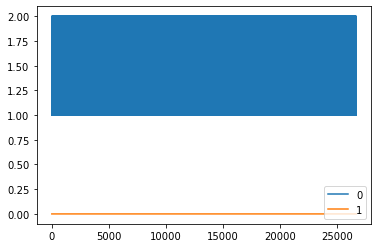

In [148]:
df.groupby('Target')['class_no'].plot(legend=True)

## Other EDA  (TBD)....

## Split X & Y and get train and test

In [149]:
X = df['actual_image']     
Y = df['class_no']

In [150]:
X

0        [[8.286463581287197e-05, 4.041750331910769e-05...
1        [[7.194814904496719e-05, 0.0002037581145740258...
2        [[4.487527018563684e-05, 4.5375053597157953e-0...
3        [[0.0002417167778605627, 0.0002527935192363741...
4        [[6.772987099858779e-05, 0.0003000979514369435...
                               ...                        
26679    [[7.163705612606939e-05, 6.700455796513645e-05...
26680    [[4.6134528863375316e-05, 4.610083468755934e-0...
26681    [[0.0003491565798057978, 0.000770259978522427,...
26682    [[1.344063738425597e-05, 4.654971683902636e-07...
26683    [[0.00026488671541695987, 0.000284427266758785...
Name: actual_image, Length: 26684, dtype: object

## Convert to tensor and start basic classification model

In [152]:
import torch
import torchvision.transforms as transforms
import tensorflow as tf

In [155]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=143)

In [156]:
from skimage.color import gray2rgb

X_train = gray2rgb(x_train.to_list())
X_test = gray2rgb(x_test.to_list())

In [159]:
print(f"{X_train.shape} is X_train shape, {X_test.shape} X_test shape, {y_train.shape} is y_train shape, {y_test.shape} y_test shape")

(18678, 32, 32, 3) is X_train shape, (8006, 32, 32, 3) X_test shape, (18678,) is y_train shape, (8006,) y_test shape


In [160]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Activation, Conv2D, Dropout, Dense, Flatten, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras import optimizers

In [167]:
def get_model():
    model = Sequential()
    
    model.add(InputLayer(input_shape = (32,32,3,)))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(GlobalMaxPool2D())

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(12, activation='softmax'))
    return model

In [168]:
#optimizer = Adam(learning_rate=0.001)
model = get_model()
model.compile(optimizer='SGD', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 15, 15, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                      

In [170]:
model.fit(X_train, y_train, epochs = 25, validation_data=(X_test, y_test))

Epoch 1/25
584/584 [==============================] - 31s 53ms/step - loss: 0.8237 - accuracy: 0.6168 - val_loss: 0.8101 - val_accuracy: 0.6245
Epoch 2/25
584/584 [==============================] - 31s 54ms/step - loss: 0.7918 - accuracy: 0.6318 - val_loss: 0.7592 - val_accuracy: 0.6371
Epoch 3/25
584/584 [==============================] - 33s 57ms/step - loss: 0.7732 - accuracy: 0.6423 - val_loss: 1.0110 - val_accuracy: 0.4926
Epoch 4/25
584/584 [==============================] - 41s 69ms/step - loss: 0.7586 - accuracy: 0.6501 - val_loss: 0.8150 - val_accuracy: 0.6212
Epoch 5/25
584/584 [==============================] - 34s 58ms/step - loss: 0.7475 - accuracy: 0.6524 - val_loss: 0.7942 - val_accuracy: 0.6248
Epoch 6/25
584/584 [==============================] - 39s 66ms/step - loss: 0.7350 - accuracy: 0.6630 - val_loss: 0.7410 - val_accuracy: 0.6584
Epoch 7/25
584/584 [==============================] - 34s 59ms/step - loss: 0.7222 - accuracy: 0.6678 - val_loss: 0.8486 - val_accuracy: